In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import pytorch_lightning as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models import ResNet18_Weights
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Register matplotlib converters
pd.plotting.register_matplotlib_converters()

# IPython magic commands (for Jupyter notebooks)
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing custom help tool
from help_tool import help_tool

In [2]:
train_dir = 'Archive/Split/Train'
validate_dir = 'Archive/Split/Validate'
test_dir = 'Archive/Split/Test'

In [3]:
classes  = [entry.name for entry in Path(train_dir).iterdir() if entry.is_dir()]

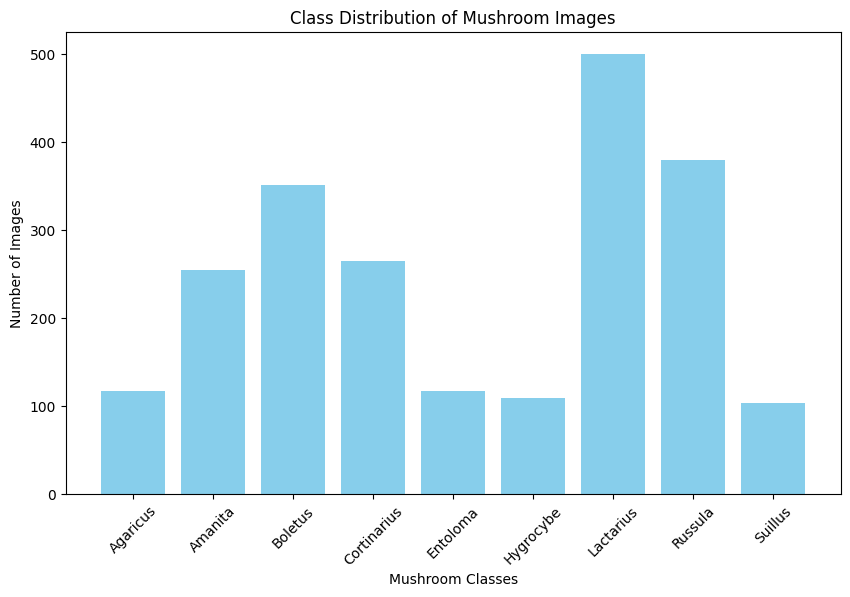

In [4]:
help_tool.plot_image_distribution(train_dir)

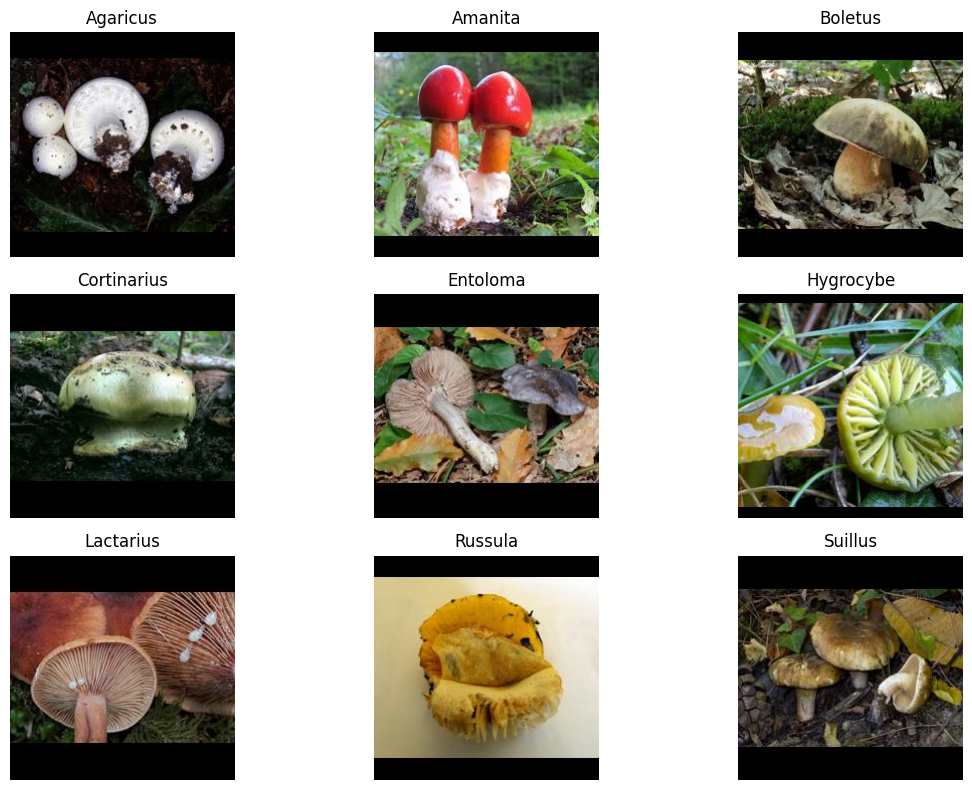

In [5]:
help_tool.visualize_sample_images(train_dir)

# Data Transformations

Define Data Augmentation

In [6]:
# Define PyTorch transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image to a size of 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(validate_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

In [8]:
# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, shuffle=False, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=False, persistent_workers=True)

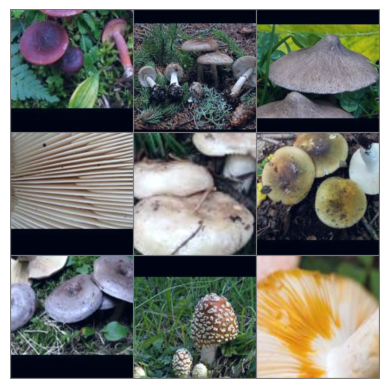

In [9]:
def sample_show(dataset):

    data_loader = DataLoader(dataset, batch_size=9, shuffle=True)

    # Get a batch of images
    data_iter = iter(data_loader)
    images, _ = next(data_iter)

    img_grid = torchvision.utils.make_grid(images, nrow=3)

    img = img_grid * 0.229 + 0.485
    img = torch.clamp(img, 0, 1)  # Clamp values to the range [0, 1] for visualization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()



sample_show(train_dataset)

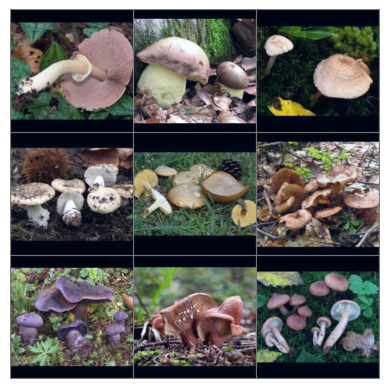

In [10]:
sample_show(val_dataset)

# Dummy Model
Dummy model with FastAI shows 70% Accuracy.

In [11]:
from fastai.vision.all import *

# Step 1: Load your data
path = Path('Archive\Split')
dls = ImageDataLoaders.from_folder(path, train='Train', valid='Validate', item_tfms=Resize(224))


In [12]:
# Step 2: Create a learner with appropriate metrics
learn = vision_learner(
    dls, 
    resnet18, 
    metrics=[
        accuracy, 
        Precision(average='macro'), 
        Recall(average='macro'), 
        F1Score(average='macro')
    ]
)

# Step 3: Train the model
learn.fine_tune(epochs=5)

# Step 4: Evaluate the model
results = learn.validate()
print(f"Validation results - Loss: {results[0]:.2f}, Accuracy: {results[1]:.2f}, Precision: {results[2]:.2f}, Recall: {results[3]:.2f}, F1 Score: {results[4]:.2f}")


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.520749,1.281953,0.597087,0.537513,0.526379,0.524288,00:13


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.357962,1.118797,0.639320,0.590080,0.568229,0.571735,00:14
1,0.931652,1.019493,0.680097,0.663464,0.608367,0.625728,00:14
2,0.562026,1.027918,0.693689,0.671872,0.643508,0.651603,00:15
3,0.324938,0.956308,0.705825,0.673895,0.645390,0.656145,00:14
4,0.205862,0.963619,0.709223,0.680607,0.653230,0.662064,00:14


Validation results - Loss: 0.96, Accuracy: 0.71, Precision: 0.68, Recall: 0.65, F1 Score: 0.66


In [13]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Suillus\\068_vev9iMcQQU8.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: Lactarius, Probability: 0.7899


In [14]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: Lactarius, Probability: 0.8167


In [15]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

# Step 6: Save and load the model
learn.save('model_name')
learn.load('model_name')

Prediction: Lactarius, Probability: 0.8167


# Model

Load and Modify ResNet18:
* models.resnet18(pretrained=True) loads the pretrained ResNet18 model.
* self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) replaces the final fully connected layer to output the correct number of classes.

Define the LightningModule:
* forward: Defines the forward pass.
* training_step: Computes the training loss.
* validation_step: Computes the validation loss.
* configure_optimizers: Configures the optimizer.

Train the Model:
* Trainer(max_epochs=10): Creates a Trainer object to train the model for 10 epochs.
* trainer.fit(model, train_loader, val_loader): Starts the training process using the specified training and validation data loaders.

* ADAM: Combines weight decay with the gradient update, which can result in a less effective regularization method because the weight decay term is scaled by the learning rate and the adaptive moment estimates.
* ADAMW: Decouples weight decay from the gradient update, applying it directly to the weights after the gradient update. This approach leads to a more effective regularization method that can improve model generalization and is conceptually clearer.

Model has frozen layers apart from last one, as the task labels are scarce (to ovoid overfitting). In case of plentiful task labels, it would be OK to use Fine-Tuning on all layers.

In [16]:
# Define the Lightning Module
class MyLightningModule(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        #criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [49]:
# Get the number of classes
classes = train_dataset.classes
num_classes = len(classes)

In [50]:
num_classes

9

In [17]:
# Get the number of classes
classes = train_dataset.classes
num_classes = len(classes)

# Instantiate the model
model = MyLightningModule(num_classes=num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'
)


# Define TensorBoard logger
tb_logger = TensorBoardLogger("tb_logs", name="mushroom_classification")


# Define the trainer
trainer = Trainer(
    max_epochs=35, 
    callbacks=[checkpoint_callback], 
    log_every_n_steps=1,
    logger=tb_logger
)

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.56117 (best 0.56117), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=00-val_accuracy=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.60777 (best 0.60777), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=01-val_accuracy=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' reached 0.61456 (best 0.61456), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=02-val_accuracy=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' reached 0.63252 (best 0.63252), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=03-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' reached 0.65922 (best 0.65922), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=04-val_accuracy=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' reached 0.66942 (best 0.66942), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=06-val_accuracy=0.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' reached 0.67913 (best 0.67913), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=08-val_accuracy=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' reached 0.68641 (best 0.68641), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=10-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' reached 0.68883 (best 0.68883), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=11-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' reached 0.68981 (best 0.68981), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=16-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' reached 0.69175 (best 0.69175), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=27-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' reached 0.69272 (best 0.69272), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=32-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


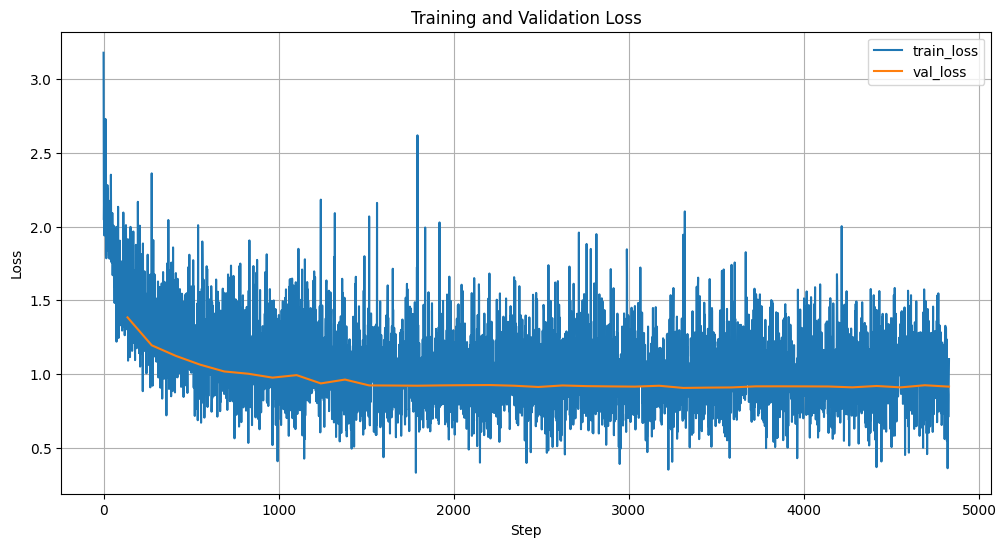

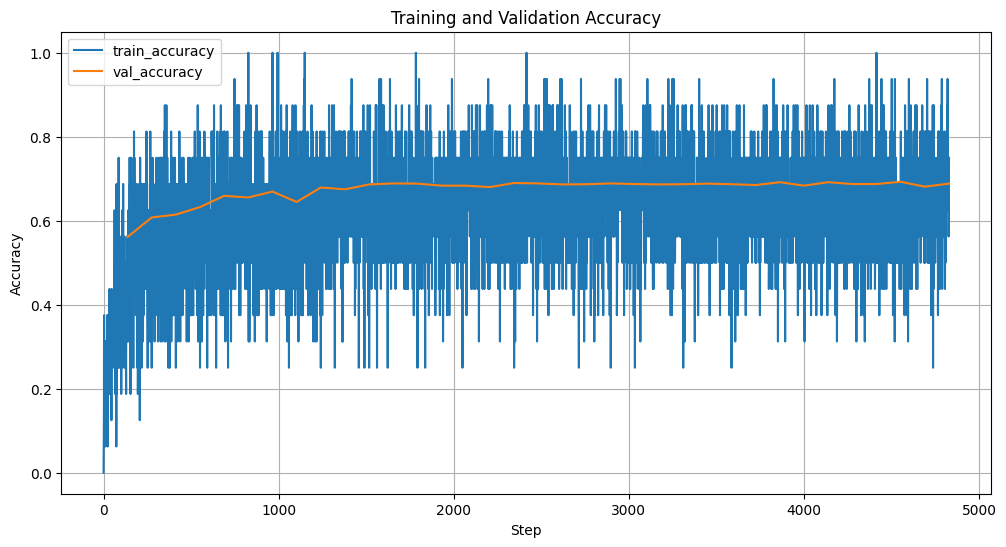

In [69]:

help_tool.loss_accuracy_plots('tb_logs\mushroom_classification\\version_1\events.out.tfevents.1722431218.Sharaz-PC.15716.0')

Saving best run in a different place

In [29]:
best_model = MyLightningModule.load_from_checkpoint("checkpoints\\mushroom-classifier-epoch=32-val_accuracy=0.69.ckpt")
torch.save(best_model, 'transfer_learning_model.pth')
best_model = torch.load('transfer_learning_model.pth')

In [27]:
summary(best_model.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Inference time of neural networks
Inference time in milliseconds on a GPU is 3.5 ms. Taken from <https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f>

In [68]:
help_tool.mean_inference_time(best_model)

Mean Inference = 3.50 [ms], Standard deviation = 0.86 [ms]


# Confusion Matrix

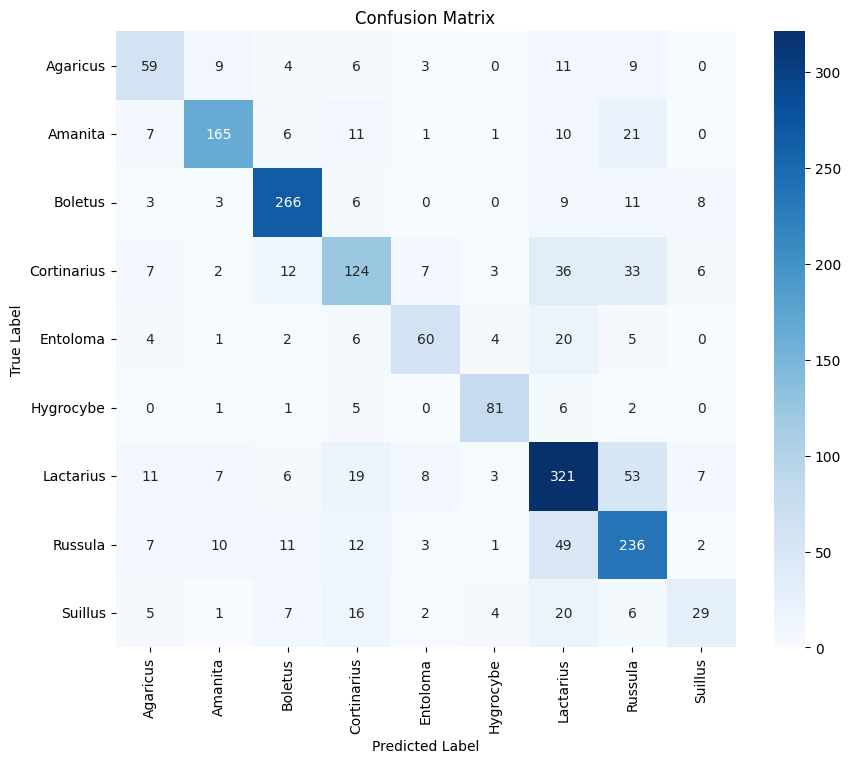

In [64]:
help_tool.confusion_matrix_plot(best_model, test_dataset, test_loader)

In [71]:
help_tool.get_model_metrics(best_model, test_dataset, batch_size)

Accuracy: 0.7010
Precision: 0.6947
Recall: 0.6601
F1 Score: 0.6722


<!-- checkpoint.keys() -->

# SGD Optimizer

SGD with Momentum: 
Stochastic Gradient Descent (SGD) with momentum is a classic choice. Momentum helps accelerate SGD in the relevant direction and dampens oscillations. This method is widely used in many types of neural networks and has proven effective, especially for training large models and on large datasets.

In [34]:
# Define the Lightning Module
class MyLightningModule_SGD(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule_SGD, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = SGD(self.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [37]:
model = MyLightningModule_SGD(num_classes=num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.49660 (best 0.49660), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=00-val_accuracy=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.58835 (best 0.58835), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=01-val_accuracy=0.59.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' reached 0.62330 (best 0.62330), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=02-val_accuracy=0.62.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' reached 0.63058 (best 0.63058), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=03-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' reached 0.63204 (best 0.63204), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=04-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' reached 0.65777 (best 0.65777), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=06-val_accuracy=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' reached 0.66019 (best 0.66019), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=07-val_accuracy=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' reached 0.66748 (best 0.66748), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=09-val_accuracy=0.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' reached 0.67184 (best 0.67184), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=10-val_accuracy=0.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' reached 0.68301 (best 0.68301), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=11-val_accuracy=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' reached 0.68544 (best 0.68544), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=12-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' reached 0.68689 (best 0.68689), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=13-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' reached 0.69029 (best 0.69029), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=15-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' reached 0.69078 (best 0.69078), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=29-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


In [39]:
best_model_sgd = MyLightningModule.load_from_checkpoint("checkpoints\\mushroom-classifier-epoch=29-val_accuracy=0.69.ckpt")
torch.save(best_model_sgd, 'transfer_learning_model_SGD.pth')
best_model_sgd = torch.load('transfer_learning_model_SGD.pth')

In [70]:
help_tool.mean_inference_time(best_model_sgd)

Mean Inference = 3.43 [ms], Standard deviation = 0.79 [ms]


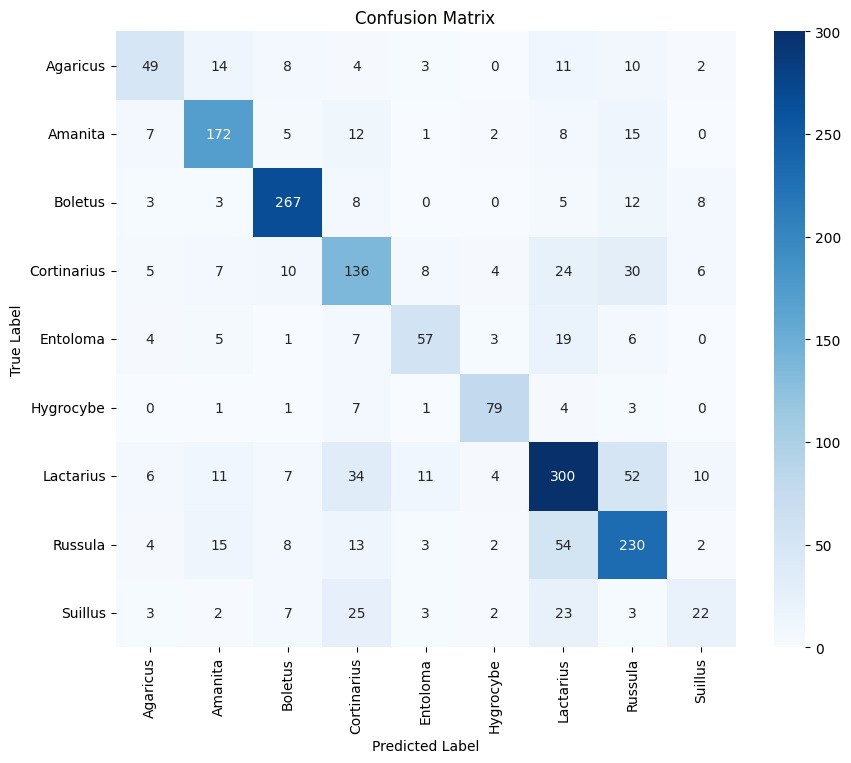

In [40]:
confusion_matrix_plot(best_model_sgd, train_dataset)

In [85]:
help_tool.get_model_metrics(best_model_sgd, test_dataset, batch_size)

Accuracy: 0.6858
Precision: 0.6645
Recall: 0.6372
F1 Score: 0.6463


# Intermediate layer between the backbone and output layer

In [82]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights
import torchmetrics
from pytorch_lightning import LightningModule
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

class MyLightningModule_New_Layer(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule_New_Layer, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the second-to-last layer (average pooling layer) with a new layer
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # Define new layers
        num_ftrs = self.model.fc.in_features
        self.new_layer = nn.Sequential(
            nn.Linear(num_ftrs, 512),  # New layer
            nn.ReLU(),                 # Activation
            nn.Dropout(0.5),           # Dropout
            nn.Linear(512, num_classes)  # Final layer
        )

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        x = self.model(x)  # Forward through ResNet18
        x = x.flatten(start_dim=1)  # Flatten for the new layers
        x = self.new_layer(x)  # Forward through new layers
        return x

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}


In [83]:
model = MyLightningModule_New_Layer(num_classes=num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | model           | ResNet              | 11.7 M | train
1  | new_layer       | Sequential          | 267 K  | train
2  | criterion       | CrossEntropyLoss    | 0      | train
3  | train_accuracy  | MulticlassAccuracy  | 0      | train
4  | train_precision | MulticlassPrecision | 0      | train
5  | train_recall    | MulticlassRecall    | 0      | train
6  | train_f1        | MulticlassF1Score   | 0      | train
7  | val_accuracy    | MulticlassAccuracy  | 0      | train
8  | val_precision   | MulticlassPrecision | 0      | train
9  | val_recall      | MulticlassRecall    | 0      | train
10 | val_f1          | MulticlassF1Score   | 0      | train
-----------------------------------------------------------------
267 K     Trainable params
11.7 M    Non-trainable params
12.0 M    Total params
47.827    Total estimate

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1000 and 512x512)